### How to open a github ipynb in google colab?

Replacing `https://github.com` by `https://colab.research.google.com/github` as mentioned in [stackoverflow](https://stackoverflow.com/questions/62596466/how-can-i-run-notebooks-of-a-github-project-in-google-colab)

In [1]:
%matplotlib inline

In [2]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && unzip PennFudanPed.zip

--2025-08-15 03:20:25--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  29.8MB/s    in 1.7s    

2025-08-15 03:20:27 (29.8 MB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPe

In [3]:
!git clone https://github.com/s-reaungamornrat/video_processing.git


Cloning into 'video_processing'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 94 (delta 35), reused 82 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (94/94), 6.27 MiB | 10.73 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [4]:
from video_processing.mask_rcnn.utils.utils import read_annotation, display_image_overlay

image  <class 'torch.Tensor'> torch.Size([3, 438, 567]) torch.uint8
mask  <class 'torch.Tensor'> torch.Size([1, 438, 567]) torch.uint8
{'obj_num': [1, 2, 3, 4], 'label': ['PASpersonWalking', 'PASpersonWalking', 'PASpersonStanding', 'PASpersonWalking'], 'bbox': [[[178, 123], [271, 410]], [[299, 114], [370, 335]], [[446, 104], [507, 315]], [[521, 119], [565, 258]]]}


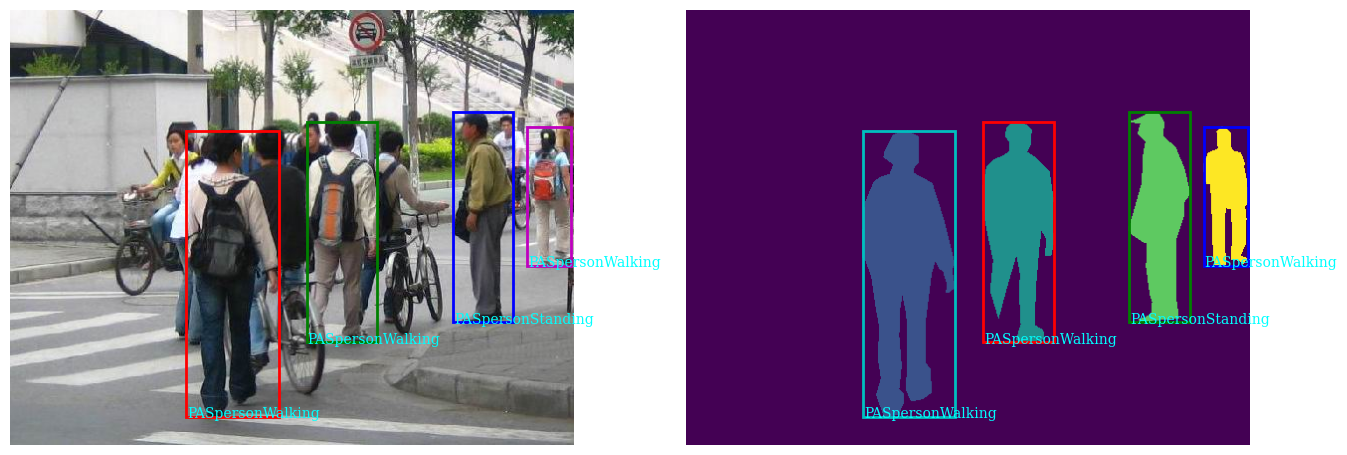

In [5]:
from torchvision.io import read_image

image=read_image('data/PennFudanPed/PNGImages/FudanPed00046.png') # CxHxW -> CxYxX
mask=read_image('data/PennFudanPed/PedMasks/FudanPed00046_mask.png') # CxHxW -> CxYxX
print('image ', type(image), image.shape, image.dtype)
print('mask ', type(mask), mask.shape, mask.dtype)

annotation=read_annotation('data/PennFudanPed/Annotation/FudanPed00046.txt')
print(annotation)
display_image_overlay(image=image, mask=mask, annotation=annotation)

In [6]:
import os
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [7]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device ', device)

num_classes=2
# load an instance segmentation model pre-trained on COCO
model=torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='DEFAULT')
# # get number of input features for the classifier
# in_features=model.roi_heads.box_predictor.cls_score.in_features
# print('the number of inpute features for classifiers ', in_features)
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor=FastRCNNPredictor(in_features,  num_classes)

# # get the number of input features for the mask classifiers
# in_features_mask=model.roi_heads.mask_predictor.conv5_mask.in_channels
# print('the number of input features for mask ', in_features_mask)
# hidden_layer=256
# # and replace the mask predictor with a new one
# model.roi_heads.mask_predictor=MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# move model to the right device
model.to(device)

device  cpu


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:01<00:00, 136MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [8]:
import torch

import utils
from video_processing.mask_rcnn.dataset.penn_fudan_ped import PennFudanDataset, get_transform

train_dataset=PennFudanDataset(root='data/PennFudanPed', image_dirname='PNGImages', mask_dirname='PedMasks', annotation_dirname='Annotation',
                         transforms=get_transform(is_train=True))#, image_mean=model.transform.image_mean, image_std=model.transform.image_std,
                                                  #min_size=model.transform.min_size, max_size=model.transform.max_size))

# define training and validation data loaders
tarin_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2,shuffle=True,collate_fn=utils.collate_fn)

2  images  [torch.Size([3, 399, 683]), torch.Size([3, 368, 542])] [(torch.float32, tensor(0.), tensor(1.)), (torch.float32, tensor(0.), tensor(1.))]
2  targets  [{'boxes': torch.Size([3, 4]), 'masks': torch.Size([3, 399, 683]), 'labels': torch.Size([3]), 'image_id': 89, 'area': torch.Size([3]), 'iscrowd': torch.Size([3])}, {'boxes': torch.Size([4, 4]), 'masks': torch.Size([4, 368, 542]), 'labels': torch.Size([4]), 'image_id': 87, 'area': torch.Size([4]), 'iscrowd': torch.Size([4])}]
masks  [(torch.uint8, tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8)), (torch.uint8, tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8))]


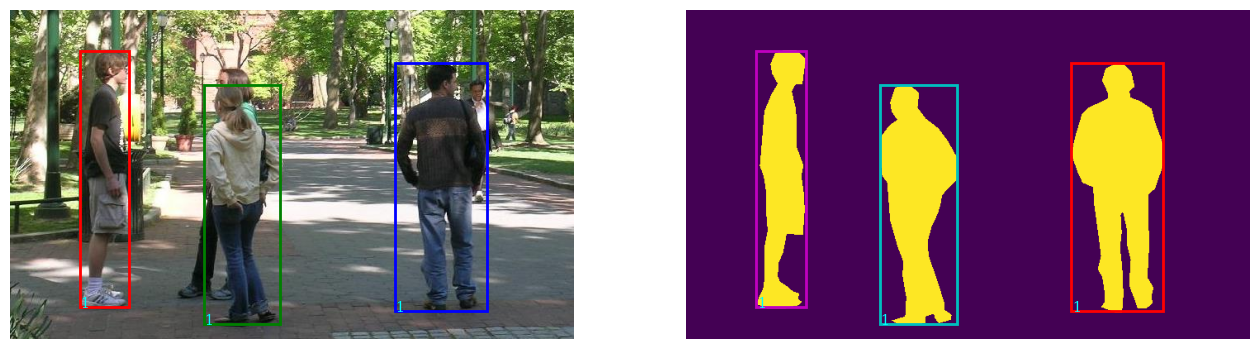

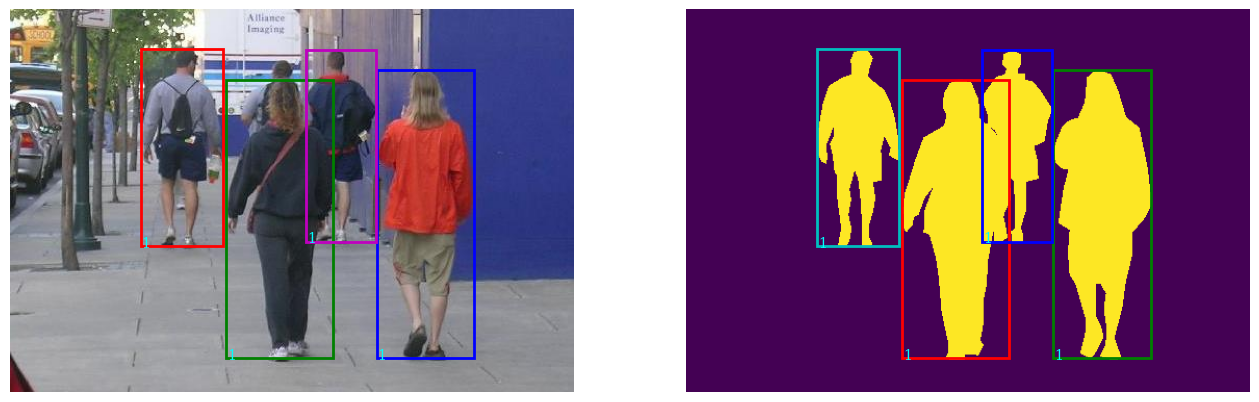

In [9]:
# For training
images, targets=next(iter(tarin_loader))
print(len(images), ' images ', [x.shape for x in images], [(x.dtype, x.min(), x.max()) for x in images])
print(len(targets), ' targets ', [{k:(v if not isinstance(v, torch.Tensor) else v.shape) for k, v in target.items()} for target in targets])
print('masks ', [(target['masks'].dtype, target['masks'].min(), target['masks'].max()) for target in targets])


for i in range(len(images)):
  annotation={'bbox':[[box.squeeze()[2*i:(2*i+2)] for i in range(2)] for box in targets[i]['boxes'].split(1, dim=0)],
              'label':[f'{l}' for l in targets[i]['labels']]}
  display_image_overlay(image=(images[i]*255).type(torch.uint8), mask=targets[i]['masks'].sum(dim=0, keepdim=True), annotation=annotation)

In [ ]:
model.backbone

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [ ]:
print('body return_layers ', model.backbone.body.return_layers)
model.backbone.body

body return_layers  {'layer1': '0', 'layer2': '1', 'layer3': '2', 'layer4': '3'}


IntermediateLayerGetter(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
model.backbone.fpn

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer_blocks): ModuleList(
    (0-3): 4 x Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1,

In [ ]:
model.rpn

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [ ]:
model.roi_heads.mask_roi_pool

MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(14, 14), sampling_ratio=2)

In [ ]:
model.roi_heads.mask_head

MaskRCNNHeads(
  (0): Conv2dNormActivation(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Conv2dNormActivation(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Conv2dNormActivation(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (3): Conv2dNormActivation(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
)

In [ ]:
model.roi_heads.mask_predictor

MaskRCNNPredictor(
  (conv5_mask): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
  (relu): ReLU(inplace=True)
  (mask_fcn_logits): Conv2d(256, 91, kernel_size=(1, 1), stride=(1, 1))
)

2  images  [torch.Size([3, 350, 452]), torch.Size([3, 474, 608])] [(torch.float32, tensor(0.), tensor(1.)), (torch.float32, tensor(0.), tensor(1.))]
2  targets  [{'boxes': torch.Size([4, 4]), 'masks': torch.Size([4, 350, 452]), 'labels': torch.Size([4]), 'image_id': 122, 'area': torch.Size([4]), 'iscrowd': torch.Size([4])}, {'boxes': torch.Size([1, 4]), 'masks': torch.Size([1, 474, 608]), 'labels': torch.Size([1]), 'image_id': 31, 'area': torch.Size([1]), 'iscrowd': torch.Size([1])}]
masks  [(torch.uint8, tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8)), (torch.uint8, tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8))]


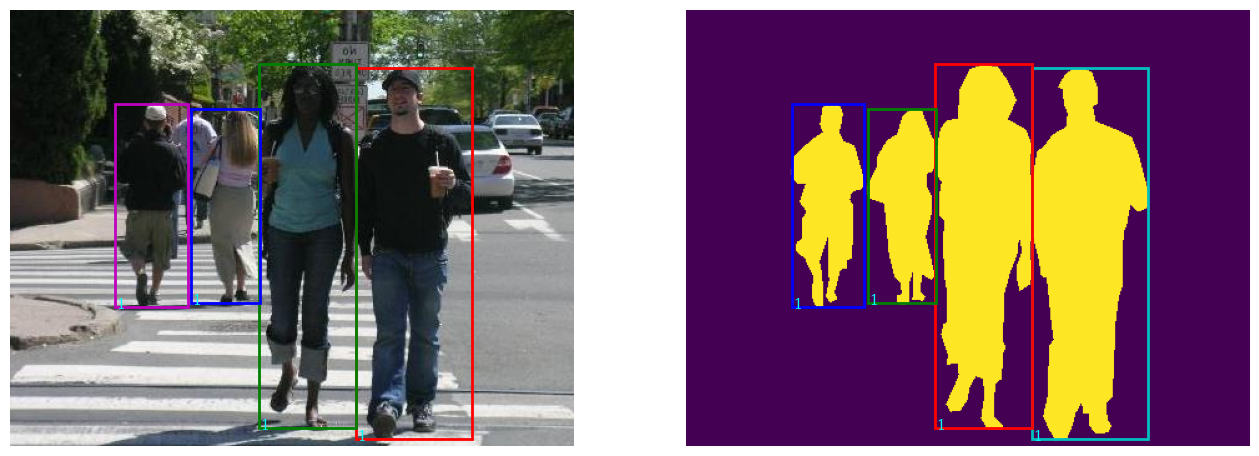

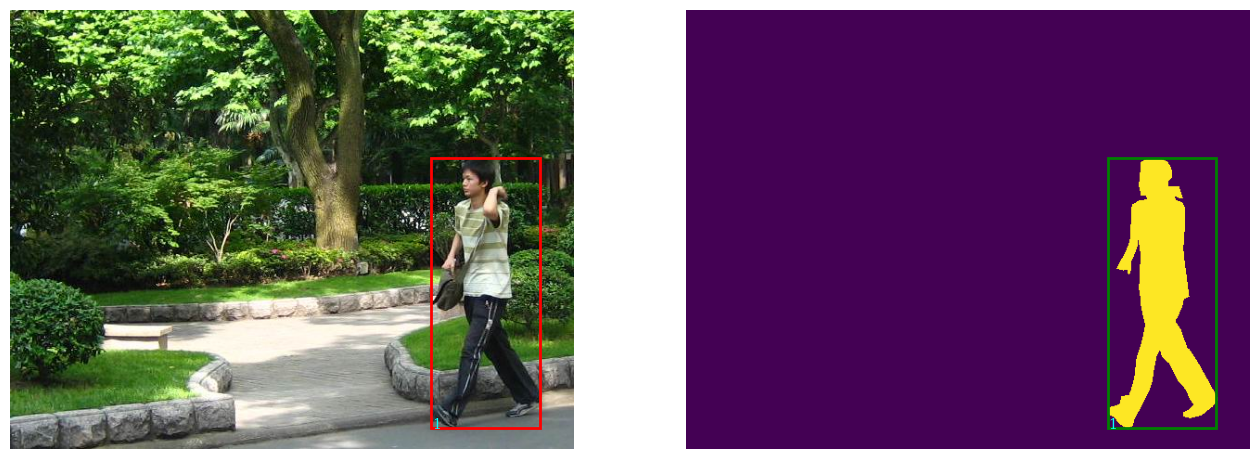

In [10]:
# For training
images, targets=next(iter(tarin_loader))
print(len(images), ' images ', [x.shape for x in images], [(x.dtype, x.min(), x.max()) for x in images])
print(len(targets), ' targets ', [{k:(v if not isinstance(v, torch.Tensor) else v.shape) for k, v in target.items()} for target in targets])
print('masks ', [(target['masks'].dtype, target['masks'].min(), target['masks'].max()) for target in targets])


for i in range(len(images)):
    annotation={'bbox':[[box.squeeze()[2*i:(2*i+2)] for i in range(2)] for box in targets[i]['boxes'].split(1, dim=0)],
              'label':[f'{l}' for l in targets[i]['labels']]}
    display_image_overlay(image=(images[i]*255).type(torch.uint8), mask=targets[i]['masks'].sum(dim=0, keepdim=True), annotation=annotation)

### Training `forward()`

In [11]:
# check that bounding box size is correct
for target in targets:
    boxes=target['boxes']
    if isinstance(boxes, torch.Tensor):
        assert(len(boxes.shape)==2 and boxes.shape[-1]==4), f'Expected target boxes to be a tensor of shape [N,4], got {boxes.shape}'
    else:
        assert False, f'Expected target boxes to be of type Tensor, got {type(boxes)}.'

In [12]:
# check for degenerate boxes
for target_idx, target in enumerate(targets):
    boxes=target['boxes']
    # Nx2 because this check element wise whether x2, y2 <= x1, y1
    degenerate_boxes=boxes[:,2:]<=boxes[:, :2]
    if degenerate_boxes.any():
        bb_idx=torch.where(degenerate_boxes.any(dim=1)) # which box in N and which dimension, e.g., box 1 along y dim
        degen_bb=boxes[bb_idx].tolist()
        assert False, f'All bounding boxes should have positive height and width\nFound invalid box {degen_bb} for target at index {target_idx}'

In [13]:
original_image_sizes=[]
for img in images:
    size=img.shape[-2:]
    print(img.shape, img.min(), img.max())
    assert len(size)==2, f'Expect the last two dimensions of the Tensor to be H and W, but got {img.shape[-2:]} instead'
    original_image_sizes.append((size[0], size[1]))
print('original_image_sizes ', original_image_sizes)

torch.Size([3, 350, 452]) tensor(0.) tensor(1.)
torch.Size([3, 474, 608]) tensor(0.) tensor(1.)
original_image_sizes  [(350, 452), (474, 608)]


In [14]:
targets[0]['boxes'], targets[0]['area']

(tensor([[278.,  47., 371., 345.],
         [200.,  44., 278., 336.],
         [146.,  80., 201., 236.],
         [ 85.,  76., 143., 239.]]),
 tensor([27714., 22776.,  8580.,  9454.]))

In [15]:
images_, targets_ = model.transform(images, targets)
print('images_ ', images_.tensors.shape, images_.tensors.min(), images_.tensors.max())
for i in range(len(targets_)):
    print('targets_ ', {k:(v.shape, v.min(), v.max(), v.dtype) if isinstance(v,torch.Tensor) else v for k, v in targets_[0].items()})
targets_[0]['boxes']

images_  torch.Size([2, 3, 800, 1056]) tensor(-2.1179) tensor(2.6400)
targets_  {'boxes': (torch.Size([4, 4]), tensor(100.5714), tensor(847.8828), torch.float32), 'masks': (torch.Size([4, 800, 1033]), tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8), torch.uint8), 'labels': (torch.Size([4]), tensor(1), tensor(1), torch.int64), 'image_id': 122, 'area': (torch.Size([4]), tensor(8580.), tensor(27714.), torch.float32), 'iscrowd': (torch.Size([4]), tensor(0), tensor(0), torch.int64)}
targets_  {'boxes': (torch.Size([4, 4]), tensor(100.5714), tensor(847.8828), torch.float32), 'masks': (torch.Size([4, 800, 1033]), tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8), torch.uint8), 'labels': (torch.Size([4]), tensor(1), tensor(1), torch.int64), 'image_id': 122, 'area': (torch.Size([4]), tensor(8580.), tensor(27714.), torch.float32), 'iscrowd': (torch.Size([4]), tensor(0), tensor(0), torch.int64)}


tensor([[635.3407, 107.4286, 847.8828, 788.5715],
        [457.0797, 100.5714, 635.3407, 768.0001],
        [333.6682, 182.8571, 459.3651, 539.4286],
        [194.2589, 173.7143, 326.8120, 546.2858]])

### Backbone Body

The `forward` function is from [`generalized_rcnn.py`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/generalized_rcnn.py) which is the base class of [`FasterRCNN`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py) and [`MaskRCNN`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/mask_rcnn.py).

The `backbone` with `fpn` is defined in [`backbone_utils.py`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/backbone_utils.py)

In [20]:
from collections import OrderedDict

x=images_.tensors
print('x ', x.shape, x.min(), x.max())
print('return layers ', model.backbone.body.return_layers)
# we first pass the input images to body in the backbone (i.e., not FPN)
out = OrderedDict()
for name, module in model.backbone.body.items():
    x = module(x)
    print(name, x.shape)
    if name in model.backbone.body.return_layers:
        out_name = model.backbone.body.return_layers[name]
        out[out_name] = x
        print(name, out_name, x.shape)
print('\n\nout ', {k:(x.shape, x.min(), x.max(), x.dtype) for k, x in out.items()})

x  torch.Size([2, 3, 800, 1056]) tensor(-2.1179) tensor(2.6400)
return layers  {'layer1': '0', 'layer2': '1', 'layer3': '2', 'layer4': '3'}
conv1 torch.Size([2, 64, 400, 528])
bn1 torch.Size([2, 64, 400, 528])
relu torch.Size([2, 64, 400, 528])
maxpool torch.Size([2, 64, 200, 264])
layer1 torch.Size([2, 256, 200, 264])
layer1 0 torch.Size([2, 256, 200, 264])
layer2 torch.Size([2, 512, 100, 132])
layer2 1 torch.Size([2, 512, 100, 132])
layer3 torch.Size([2, 1024, 50, 66])
layer3 2 torch.Size([2, 1024, 50, 66])
layer4 torch.Size([2, 2048, 25, 33])
layer4 3 torch.Size([2, 2048, 25, 33])


out  {'0': (torch.Size([2, 256, 200, 264]), tensor(0.), tensor(3.0677), torch.float32), '1': (torch.Size([2, 512, 100, 132]), tensor(0., grad_fn=<MinBackward1>), tensor(3.6017, grad_fn=<MaxBackward1>), torch.float32), '2': (torch.Size([2, 1024, 50, 66]), tensor(0., grad_fn=<MinBackward1>), tensor(2.1785, grad_fn=<MaxBackward1>), torch.float32), '3': (torch.Size([2, 2048, 25, 33]), tensor(0., grad_fn=<Min

### Backbone FPN

Based on code at [`feature_pyramid_network.py`](https://github.com/pytorch/vision/blob/main/torchvision/ops/feature_pyramid_network.py#L183), where `extra_blocks` from [`LastLevelMaxPool`](https://github.com/pytorch/vision/blob/main/torchvision/ops/feature_pyramid_network.py)


In [17]:
model.backbone.fpn

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer_blocks): ModuleList(
    (0-3): 4 x Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1,

In [21]:
import torch.nn.functional as F

# we then pass feature to FPN
x=out
names=list(x.keys())
x=list(x.values())
print('names ', names)
print('x ', [i.shape for i in x])

# we move from the output from the backbone-body deepest layer (having the bigger number of channels)
last_inner=model.backbone.fpn.inner_blocks[-1](x[-1])
print('last_inner ', last_inner.shape, last_inner.min(), last_inner.max())
results=[model.backbone.fpn.layer_blocks[-1](last_inner)]
print('last result ', results[0].shape, results[0].min(), results[0].max())

# we get from the one after deepest layer (i.e., top down)
for idx in range(len(x)-2, -1, -1):
    inner_lateral=model.backbone.fpn.inner_blocks[idx](x[idx])
    feat_shape=inner_lateral.shape[-2:]
    inner_top_down = F.interpolate(last_inner, size=feat_shape, mode="nearest")
    print(idx, ' last_inner ', last_inner.shape, ' feat_shape ', feat_shape, end=',')
    last_inner=inner_lateral+inner_top_down
    results.insert(0, model.backbone.fpn.layer_blocks[idx](last_inner))
    print(' updated_last_inner ', last_inner.shape, ' result ', results[0].shape)

print('\n\nresults ', [(r.shape, r.min(), r.max()) for r in results])

results, names =model.backbone.fpn.extra_blocks(results, x, names)

print('\n\nname:results ', {n:(r.shape, r.min(), r.max()) for n, r in zip(names,results)})

# make it back an OrderedDict
out=OrderedDict([(k,v) for k, v in zip(names, results)])

names  ['0', '1', '2', '3']
x  [torch.Size([2, 256, 200, 264]), torch.Size([2, 512, 100, 132]), torch.Size([2, 1024, 50, 66]), torch.Size([2, 2048, 25, 33])]
last_inner  torch.Size([2, 256, 25, 33]) tensor(-1.3128, grad_fn=<MinBackward1>) tensor(1.3081, grad_fn=<MaxBackward1>)
last result  torch.Size([2, 256, 25, 33]) tensor(-2.0342, grad_fn=<MinBackward1>) tensor(2.0227, grad_fn=<MaxBackward1>)
2  last_inner  torch.Size([2, 256, 25, 33])  feat_shape  torch.Size([50, 66]), updated_last_inner  torch.Size([2, 256, 50, 66])  result  torch.Size([2, 256, 50, 66])
1  last_inner  torch.Size([2, 256, 50, 66])  feat_shape  torch.Size([100, 132]), updated_last_inner  torch.Size([2, 256, 100, 132])  result  torch.Size([2, 256, 100, 132])
0  last_inner  torch.Size([2, 256, 100, 132])  feat_shape  torch.Size([200, 264]), updated_last_inner  torch.Size([2, 256, 200, 264])  result  torch.Size([2, 256, 200, 264])


results  [(torch.Size([2, 256, 200, 264]), tensor(-2.2970, grad_fn=<MinBackward1>), ten

### Region Proposal Network (RPN)

This is for the line
```
proposals, proposal_losses = self.rpn(images, features, targets)
```
in [`generalized_rcnn.py`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/generalized_rcnn.py) which calls `rpn` defined on [`rpn.py`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py)

In [ ]:
model.rpn.head

RPNHead(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
  (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
)

In [25]:
import numpy as np

In [22]:
# RPN uses all feature maps that are available
features=list(out.values()) # output from FPN
print('features ', [f.shape for f in features])

# call RPNHead
objectness=[] # logits
pred_bbox_deltas=[] # bbox_reg
for i, feature in enumerate(features):
    t=model.rpn.head.conv(feature)
    objectness.append(model.rpn.head.cls_logits(t))
    pred_bbox_deltas.append(model.rpn.head.bbox_pred(t)) # predict dx,dy,dw,dh
    print(i, ' feature ', feature.shape, ' t ', t.shape, ' objectness ', objectness[-1].shape, objectness[-1].min().item(),
          objectness[-1].max().item(), ' pred_bbox_deltas ', pred_bbox_deltas[-1].shape, pred_bbox_deltas[-1].min().item(),
          pred_bbox_deltas[-1].max().item())

features  [torch.Size([2, 256, 200, 264]), torch.Size([2, 256, 100, 132]), torch.Size([2, 256, 50, 66]), torch.Size([2, 256, 25, 33]), torch.Size([2, 256, 13, 17])]
0  feature  torch.Size([2, 256, 200, 264])  t  torch.Size([2, 256, 200, 264])  objectness  torch.Size([2, 3, 200, 264]) -23.073467254638672 4.841838359832764  pred_bbox_deltas  torch.Size([2, 12, 200, 264]) -2.8368561267852783 2.2961413860321045
1  feature  torch.Size([2, 256, 100, 132])  t  torch.Size([2, 256, 100, 132])  objectness  torch.Size([2, 3, 100, 132]) -20.355525970458984 7.964738368988037  pred_bbox_deltas  torch.Size([2, 12, 100, 132]) -1.8170982599258423 1.8425407409667969
2  feature  torch.Size([2, 256, 50, 66])  t  torch.Size([2, 256, 50, 66])  objectness  torch.Size([2, 3, 50, 66]) -20.63127326965332 9.071417808532715  pred_bbox_deltas  torch.Size([2, 12, 50, 66]) -1.3370084762573242 1.4190728664398193
3  feature  torch.Size([2, 256, 25, 33])  t  torch.Size([2, 256, 25, 33])  objectness  torch.Size([2, 3, 2

In [23]:
# compute anchors
print('sizes  ', model.rpn.anchor_generator.sizes )
print('aspect_ratios ', model.rpn.anchor_generator.aspect_ratios)
print(len(model.rpn.anchor_generator.cell_anchors), ' cell_anchors  ', [an.shape for an in model.rpn.anchor_generator.cell_anchors],
      model.rpn.anchor_generator.cell_anchors[0] )

grid_sizes=[feature.shape[-2:] for feature in features] # grid size of output features from FPN
image_size=images_.tensors.shape[-2:]
print('\ngrid_size ', grid_sizes, ' image_size ', image_size)
dtype,device=features[0].dtype, features[0].device
strides=[
    [torch.empty((), dtype=torch.int64, device=device).fill_(image_size[0]//g[0]),
     torch.empty((), dtype=torch.int64, device=device).fill_(image_size[1]//g[1])]
    for g in grid_sizes
]
print('stride ', strides)
# set model.rpn.anchor_generator.cell_anchors to dtype and move them to device
model.rpn.anchor_generator.set_cell_anchors(dtype, device)
anchors_over_all_feature_maps=model.rpn.anchor_generator.grid_anchors(grid_sizes, strides)
print('anchors_over_all_feature_maps ', len(anchors_over_all_feature_maps), [x.shape for x in anchors_over_all_feature_maps])
print('images_.image_sizes ', images_.image_sizes)
anchors=[]
for _ in range(images_.tensors.shape[0]):
    anchors_in_image=[anchors_per_feature_map for anchors_per_feature_map in anchors_over_all_feature_maps]
    print('anchors_in_image ', len(anchors_in_image), [i.shape for i in anchors_in_image])
    anchors.append(anchors_in_image)
anchors=[torch.cat(anchors_per_image) for anchors_per_image in anchors]
print('anchors ', len(anchors), [a.shape for a in anchors])
torch.save(anchors, 'anchors.pt')

sizes   ((32,), (64,), (128,), (256,), (512,))
aspect_ratios  ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
5  cell_anchors   [torch.Size([3, 4]), torch.Size([3, 4]), torch.Size([3, 4]), torch.Size([3, 4]), torch.Size([3, 4])] tensor([[-23., -11.,  23.,  11.],
        [-16., -16.,  16.,  16.],
        [-11., -23.,  11.,  23.]])

grid_size  [torch.Size([200, 264]), torch.Size([100, 132]), torch.Size([50, 66]), torch.Size([25, 33]), torch.Size([13, 17])]  image_size  torch.Size([800, 1056])
stride  [[tensor(4), tensor(4)], [tensor(8), tensor(8)], [tensor(16), tensor(16)], [tensor(32), tensor(32)], [tensor(61), tensor(62)]]
anchors_over_all_feature_maps  5 [torch.Size([158400, 4]), torch.Size([39600, 4]), torch.Size([9900, 4]), torch.Size([2475, 4]), torch.Size([663, 4])]
images_.image_sizes  [(800, 1033), (800, 1026)]
anchors_in_image  5 [torch.Size([158400, 4]), torch.Size([39600, 4]), torch.Size([9900, 4]), torch.Size([2475, 4]), torch.Size([663,

In [34]:
num_images=len(anchors)
print('num_images ', num_images)
num_anchors_per_level_shape_tensors=[o.shape[1:] for o in objectness] # we note that o at each level is of size BxCxHxW -->  ot sure what C is? classes, num_anchors, ...?
print('num_anchors_per_level_shape_tensors ', num_anchors_per_level_shape_tensors)
num_anchors_per_level=[np.prod(s) for s in num_anchors_per_level_shape_tensors]
print('num_anchors_per_level ', num_anchors_per_level)

num_images  2
num_anchors_per_level_shape_tensors  [torch.Size([3, 200, 264]), torch.Size([3, 100, 132]), torch.Size([3, 50, 66]), torch.Size([3, 25, 33]), torch.Size([3, 13, 17])]
num_anchors_per_level  [np.int64(158400), np.int64(39600), np.int64(9900), np.int64(2475), np.int64(663)]


In [27]:
def permute_and_flatten(layer, N, A, C, H, W):
    '''
    Change the shape of a tensor having batch size of N, height H, width W, number of anchors A, and number of channels
    to a tensor of size Nx(HWA)xC
    Input:
        layer (tensor): whose dimension must comprise N, A, C, H, W
        N (int): batch size
        A (int): number of anchors, typically equal the number of aspect ratios
        C (int): number of channels
        H (int): height
        W (int): width
    '''
    layer = layer.view(N, -1, C, H, W) # NxAxCxHxW
    layer = layer.permute(0, 3, 4, 1, 2) # NxHxWxAxC
    layer = layer.reshape(N, -1, C) # Nx(HWA)xC
    return layer

In [28]:
# The following code for the following function in https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py
#objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
box_cls=objectness
box_regression=pred_bbox_deltas

box_cls_flattened=[]
box_regression_flattened=[]
# for each feature level, permute the outputs to make them be in the same format as the labels. Note that the labels are computed for all
# feature levels concatenated, so we keep the same representation for the objectness and the box_regiression
for box_cls_per_level, box_regression_per_level in zip(box_cls, box_regression):
    N, AxC, H, W=box_cls_per_level.shape
    Ax4=box_regression_per_level.shape[1]
    A=Ax4//4
    C=AxC//A
    print('A ', A, ' C ', C, 'box_cls_per_level ', box_cls_per_level.shape, ' box_regression_per_level ', box_regression_per_level.shape)
    box_cls_per_level=permute_and_flatten(box_cls_per_level, N, A, C, H, W) # NxHWAxC
    box_cls_flattened.append(box_cls_per_level)


    box_regression_per_level = permute_and_flatten(box_regression_per_level, N, A, 4, H, W) # NxHWAxC
    box_regression_flattened.append(box_regression_per_level)
print('\nbox_cls_flattened ', len(box_cls_flattened), [i.shape for i in box_cls_flattened])
print('box_regression_flattened ', len(box_regression_flattened), [i.shape for i in box_regression_flattened])

# concatenate on the first dimension (representing the feature levels), to take into account the way the labels were generated (with all feature maps being concatenated as well)
box_cls_=torch.cat(box_cls_flattened, dim=1).flatten(start_dim=0, end_dim=-2) # Nx(HWA)xC -> NHWAxC
box_regression_=torch.cat(box_regression_flattened, dim=1).reshape(-1, 4) # Nx(HWA)xC -> NHWAxC
print('box_cls_ ', box_cls_.shape, box_cls_.requires_grad, box_cls_.dtype, box_cls_.min(), box_cls_.max())
print('box_regression_ ', box_regression_.shape, box_regression_.requires_grad, box_regression_.dtype, box_regression_.min(0).values,
      box_regression_.max(dim=0).values)

# torch.save(box_regression_, 'pred_bbox_deltas.pt')

A  3  C  1 box_cls_per_level  torch.Size([2, 3, 200, 264])  box_regression_per_level  torch.Size([2, 12, 200, 264])
A  3  C  1 box_cls_per_level  torch.Size([2, 3, 100, 132])  box_regression_per_level  torch.Size([2, 12, 100, 132])
A  3  C  1 box_cls_per_level  torch.Size([2, 3, 50, 66])  box_regression_per_level  torch.Size([2, 12, 50, 66])
A  3  C  1 box_cls_per_level  torch.Size([2, 3, 25, 33])  box_regression_per_level  torch.Size([2, 12, 25, 33])
A  3  C  1 box_cls_per_level  torch.Size([2, 3, 13, 17])  box_regression_per_level  torch.Size([2, 12, 13, 17])

box_cls_flattened  5 [torch.Size([2, 158400, 1]), torch.Size([2, 39600, 1]), torch.Size([2, 9900, 1]), torch.Size([2, 2475, 1]), torch.Size([2, 663, 1])]
box_regression_flattened  5 [torch.Size([2, 158400, 4]), torch.Size([2, 39600, 4]), torch.Size([2, 9900, 4]), torch.Size([2, 2475, 4]), torch.Size([2, 663, 4])]
box_cls_  torch.Size([422076, 1]) True torch.float32 tensor(-23.0735, grad_fn=<MinBackward1>) tensor(9.0714, grad_fn

[`BoxCoder`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/_utils.py)

we check `BoxCoder` using local machine

In [48]:
# NHWAxC, NHWAx4C,
objectness, pred_bbox_deltas=box_cls_,box_regression_
print(f'objectness {objectness.shape}, pred_bbox_deltas {pred_bbox_deltas.shape}')
# apply pred_bbox_deltas to anchors to obtain the decoded proposals
# note that we detach the deltas because Faster R-CNN do not backprop through
# the proposals
proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors) # NHWAx4C
print('proposals ', proposals.shape)
proposals = proposals.view(num_images, -1, 4) #NxHWAx4C
print('proposals ', proposals.shape)

objectness torch.Size([422076, 1]), pred_bbox_deltas torch.Size([422076, 4])
proposals  torch.Size([422076, 1, 4])
proposals  torch.Size([2, 211038, 4])


### Test [`filter_proposals`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py) in notebook

```
boxes, scores = self.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)
```

In [49]:
torch.save(proposals, "proposals.pt")
torch.save(objectness, "objectness.pt")
print('num_anchors_per_level ', num_anchors_per_level)
print('image_sizes ', images_.image_sizes)
print('_pre_nms_top_n ', model.rpn._pre_nms_top_n)
print('score_thresh ', model.rpn.score_thresh, ' nms_thresh ', model.rpn.nms_thresh)
print('_post_nms_top_n ', model.rpn._post_nms_top_n)
print('min_size ', model.rpn.min_size)

num_anchors_per_level  [np.int64(158400), np.int64(39600), np.int64(9900), np.int64(2475), np.int64(663)]
image_sizes  [(800, 1033), (800, 1026)]
_pre_nms_top_n  {'training': 2000, 'testing': 1000}
score_thresh  0.0  nms_thresh  0.7
_post_nms_top_n  {'training': 2000, 'testing': 1000}
min_size  0.001


In [46]:
objectness.shape, proposals.shape

(torch.Size([422076, 1]), torch.Size([2, 211038, 4]))

In [ ]:

        boxes, scores = self.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

images_.image_sizes  [(861, 800), (800, 1053)]
anchors_in_image  5 [torch.Size([171072, 4]), torch.Size([42768, 4]), torch.Size([10692, 4]), torch.Size([2673, 4]), torch.Size([714, 4])]
anchors_in_image  5 [torch.Size([171072, 4]), torch.Size([42768, 4]), torch.Size([10692, 4]), torch.Size([2673, 4]), torch.Size([714, 4])]
anchors  2 [torch.Size([227919, 4]), torch.Size([227919, 4])]


In [ ]:

        anchors_over_all_feature_maps = self.grid_anchors(grid_sizes, strides)
        anchors: list[list[torch.Tensor]] = []
        for _ in range(len(image_list.image_sizes)):
            anchors_in_image = [anchors_per_feature_map for anchors_per_feature_map in anchors_over_all_feature_maps]
            anchors.append(anchors_in_image)
        anchors = [torch.cat(anchors_per_image) for anchors_per_image in anchors]

In [ ]:
        # RPN uses all feature maps that are available
        features = list(features.values())
        objectness, pred_bbox_deltas = self.head(features)
        anchors = self.anchor_generator(images, features)

        num_images = len(anchors)
        num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
        num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
        objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
        # apply pred_bbox_deltas to anchors to obtain the decoded proposals
        # note that we detach the deltas because Faster R-CNN do not backprop through
        # the proposals
        proposals = self.box_coder.decode(pred_bbox_deltas.detach(), anchors)
        proposals = proposals.view(num_images, -1, 4)
        boxes, scores = self.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

        losses = {}
        if self.training:
            if targets is None:
                raise ValueError("targets should not be None")
            labels, matched_gt_boxes = self.assign_targets_to_anchors(anchors, targets)
            regression_targets = self.box_coder.encode(matched_gt_boxes, anchors)
            loss_objectness, loss_rpn_box_reg = self.compute_loss(
                objectness, pred_bbox_deltas, labels, regression_targets
            )
            losses = {
                "loss_objectness": loss_objectness,
                "loss_rpn_box_reg": loss_rpn_box_reg,
            }
